In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from mlxtend.plotting import plot_decision_regions
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql

# We are also going to do some basic viz
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('ggplot')
plt.rc('font', size=12)


In [4]:
ecom_model = pd.read_csv('ecom_model.csv')


In [5]:
ecom_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288047 entries, 0 to 288046
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 288047 non-null  int64  
 1   itemid                     288047 non-null  int64  
 2   visitorid                  288047 non-null  int64  
 3   user_product_total_orders  288047 non-null  int64  
 4   timestamp                  288047 non-null  object 
 5   event                      288047 non-null  object 
 6   transactionid              288047 non-null  float64
 7   property                   288047 non-null  object 
 8   value                      288047 non-null  int64  
 9   parentid                   288047 non-null  float64
 10  Event_Goal                 288047 non-null  int64  
 11  AddtoCart                  288047 non-null  int64  
 12  days_since_last_event      288047 non-null  float64
 13  Previous_Visits            28

In [6]:
ecom_model[['itemid','visitorid','transactionid']] = ecom_model[['itemid','visitorid','transactionid']].astype("str")

In [7]:
modeling_df = ecom_model.drop(columns=['timestamp','property','value','parentid'])

In [8]:
modeling_df.head()

,Unnamed: 0,itemid,visitorid,user_product_total_orders,event,transactionid,Event_Goal,AddtoCart,days_since_last_event,Previous_Visits,...,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,category_level
0,0,342816,2,0,view,0.0,0,0,0.0,0,...,0,0,1,0,0,0,1,0,0,3
1,1,216305,2,0,view,0.0,0,0,0.0,1,...,0,0,1,0,0,0,1,0,0,3
2,2,344723,6,0,view,0.0,0,0,0.0,0,...,0,0,0,0,1,0,0,1,0,4
3,3,65273,6,0,addtocart,0.0,0,1,0.0,1,...,0,0,0,0,1,0,0,1,0,4
4,4,330269,14,0,view,0.0,0,0,0.0,0,...,0,1,0,0,0,1,0,0,0,2


In [9]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288047 entries, 0 to 288046
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 288047 non-null  int64  
 1   itemid                     288047 non-null  object 
 2   visitorid                  288047 non-null  object 
 3   user_product_total_orders  288047 non-null  int64  
 4   event                      288047 non-null  object 
 5   transactionid              288047 non-null  object 
 6   Event_Goal                 288047 non-null  int64  
 7   AddtoCart                  288047 non-null  int64  
 8   days_since_last_event      288047 non-null  float64
 9   Previous_Visits            288047 non-null  int64  
 10  Day_of_Week_0              288047 non-null  int64  
 11  Day_of_Week_1              288047 non-null  int64  
 12  Day_of_Week_2              288047 non-null  int64  
 13  Day_of_Week_3              28

In [10]:
test_data2 = (modeling_df.groupby(['visitorid'], as_index = False)
                                         .agg({'transactionid':'count'})
            )

In [11]:
trans_id2 = test_data2.groupby('transactionid')['visitorid'].count()

In [12]:
trans_index = trans_id2.index.values.tolist()
trans_values = trans_id2.values.tolist()

<BarContainer object of 140 artists>

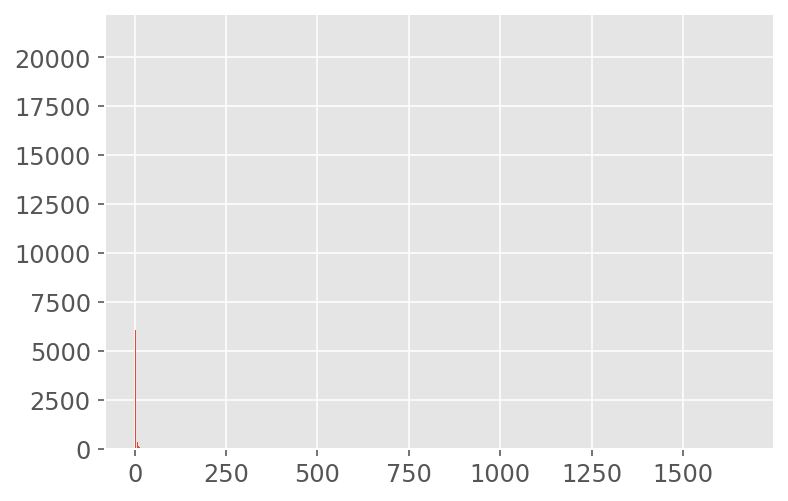

In [13]:
plt.bar(trans_index[1:], trans_values[1:])

<BarContainer object of 139 artists>

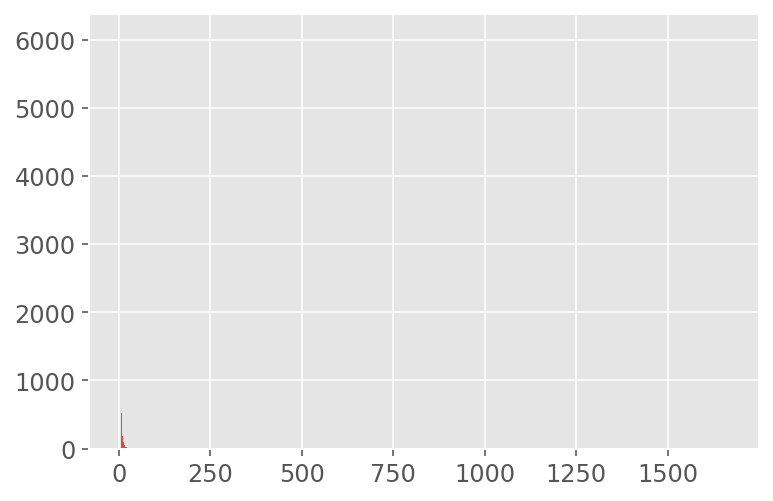

In [32]:
plt.bar(trans_index[2:], trans_values[2:])

In [33]:
test_data3 = (modeling_df.groupby(['itemid','visitorid','event'], as_index = False)
                                         .agg({'transactionid':'count'})
            )

In [34]:
test_data3['event'] = test_data3['event'].apply(lambda x: 2 if x=='addtocart' else (1 if x=='view' else -99999))

In [35]:
test_data3.sort_values(by=['visitorid'])

,itemid,visitorid,event,transactionid
70316,21180,100000,1,1
257820,77528,1000007,1,1
20735,132686,1000009,1,1
98315,25325,1000010,1,1
18254,128596,1000012,1,1
...,...,...,...,...
139320,315140,999986,2,1
108954,268897,999989,1,1
108953,268897,999989,2,1
241417,51259,999996,1,1


In [43]:
modeling_df.columns

Index(['itemid', 'visitorid', 'user_product_total_orders', 'event',
       'transactionid', 'Event_Goal', 'AddtoCart', 'days_since_last_event',
       'Previous_Visits', 'Day_of_Week_0', 'Day_of_Week_1', 'Day_of_Week_2',
       'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5', 'Day_of_Week_6',
       'Time_of_Day_Afternoon', 'Time_of_Day_Evening', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'category_level'],
      dtype='object')

In [44]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['visitorid'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['visitorid'].isin(test_users)]
    df_te = df[df['visitorid'].isin(test_users)] 

    y_tr, y_te = df_tr['Event_Goal'], df_te['Event_Goal']
    X_tr = df_tr.drop(['Event_Goal','visitorid','event'],axis=1) 
    X_te = df_te.drop(['Event_Goal','visitorid','event'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [ ]:
sns.pairplot(modeling_df)

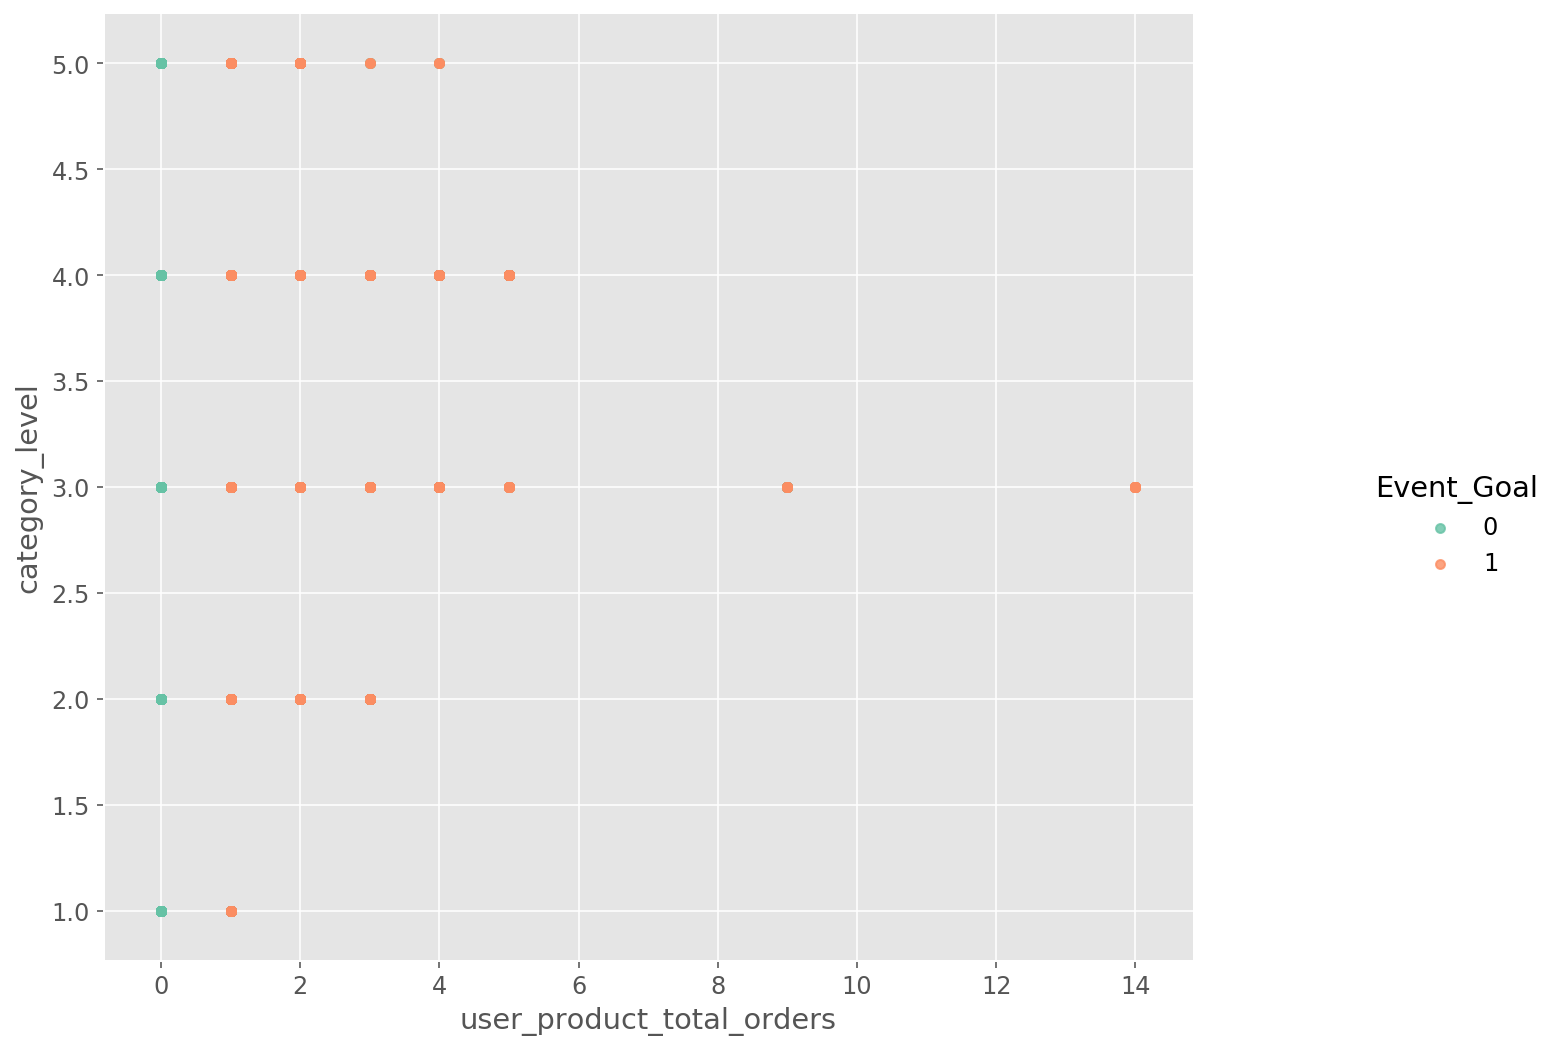

In [47]:
sns.lmplot('user_product_total_orders', 'category_level', data=modeling_df, hue='Event_Goal',
           palette='Set2', fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(12,8);

## Functions 

In [48]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [49]:
def log_reg(X_train, y_train, X_test, y_test, solver_val='lbfgs'):  
    lr = LogisticRegression(solver=solver_val)
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_pred, y_test), y_pred, model

In [50]:
def random_forest_classifier(X_train, y_train,X_test, y_test, estimators = 100, features = 10):
    rc = RandomForestClassifier(n_estimators = estimators, max_features = features)
    model = rc.fit(X_train, y_train)
    y_pred = rc.predict(X_test)
    return model, y_pred

In [ ]:
def decision_tree(X,y,X_test,y_test,depth):
    dt = DecisionTreeClassifier(max_depth=depth)
    model = dt.fit(X,y)
    y_pred = dt.predict(X_test)
    return model, y_pred

In [52]:
def naive_bayes(X_train, y_train,X_test, y_test, model = 'g'):
    """ To select model, use g for guassianNB, b for bernoulliNB, and m for multinomialNB"""
    if model == 'g':
        nb = GaussianNB()
    elif model == 'm':
        nb = MultinomialNB()
    elif model == 'b':
        nb = BernoulliNB()
    else: 
        raise ValueError('Model selection was not corret.  Use, "b" "m", or "g"')
    model = nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    return nb.score(X_test, y_test), y_pred, model

In [53]:
def knn_classifier(X,y,X_test,y_test,neigh = 5):
    pass
    knn = KNeighborsClassifier(n_neighbors=neigh)
    model = knn.fit(X, y)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred), y_pred, model



In [1]:
def svm_classifier(X,y,X_test,y_test,kernal_type = 'linear'):
    model_svm = svm.SVC(kernel= kernal_type)
    model = model_svm.fit(X, y)
    y_pred = model_svm.predict(X_test)
    return model, y_pred

In [54]:
modeling_df.head()

,itemid,visitorid,user_product_total_orders,event,transactionid,Event_Goal,AddtoCart,days_since_last_event,Previous_Visits,Day_of_Week_0,...,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,category_level
0,342816,2,0,view,0.0,0,0,0.0,0,0,...,0,0,1,0,0,0,1,0,0,3
1,216305,2,0,view,0.0,0,0,0.0,1,0,...,0,0,1,0,0,0,1,0,0,3
2,344723,6,0,view,0.0,0,0,0.0,0,0,...,0,0,0,0,1,0,0,1,0,4
3,65273,6,0,addtocart,0.0,0,1,0.0,1,0,...,0,0,0,0,1,0,0,1,0,4
4,330269,14,0,view,0.0,0,0,0.0,0,0,...,0,1,0,0,0,1,0,0,0,2


In [55]:
cat_list=[['parent',len(parent_list)],['lvl_2',len(second_list)],['lvl_3',len(third_list)],['lvl_4',len(fourth_list)],['lvl_5',len(fifth_list)],['lvl_6',len(sixth_list)]]

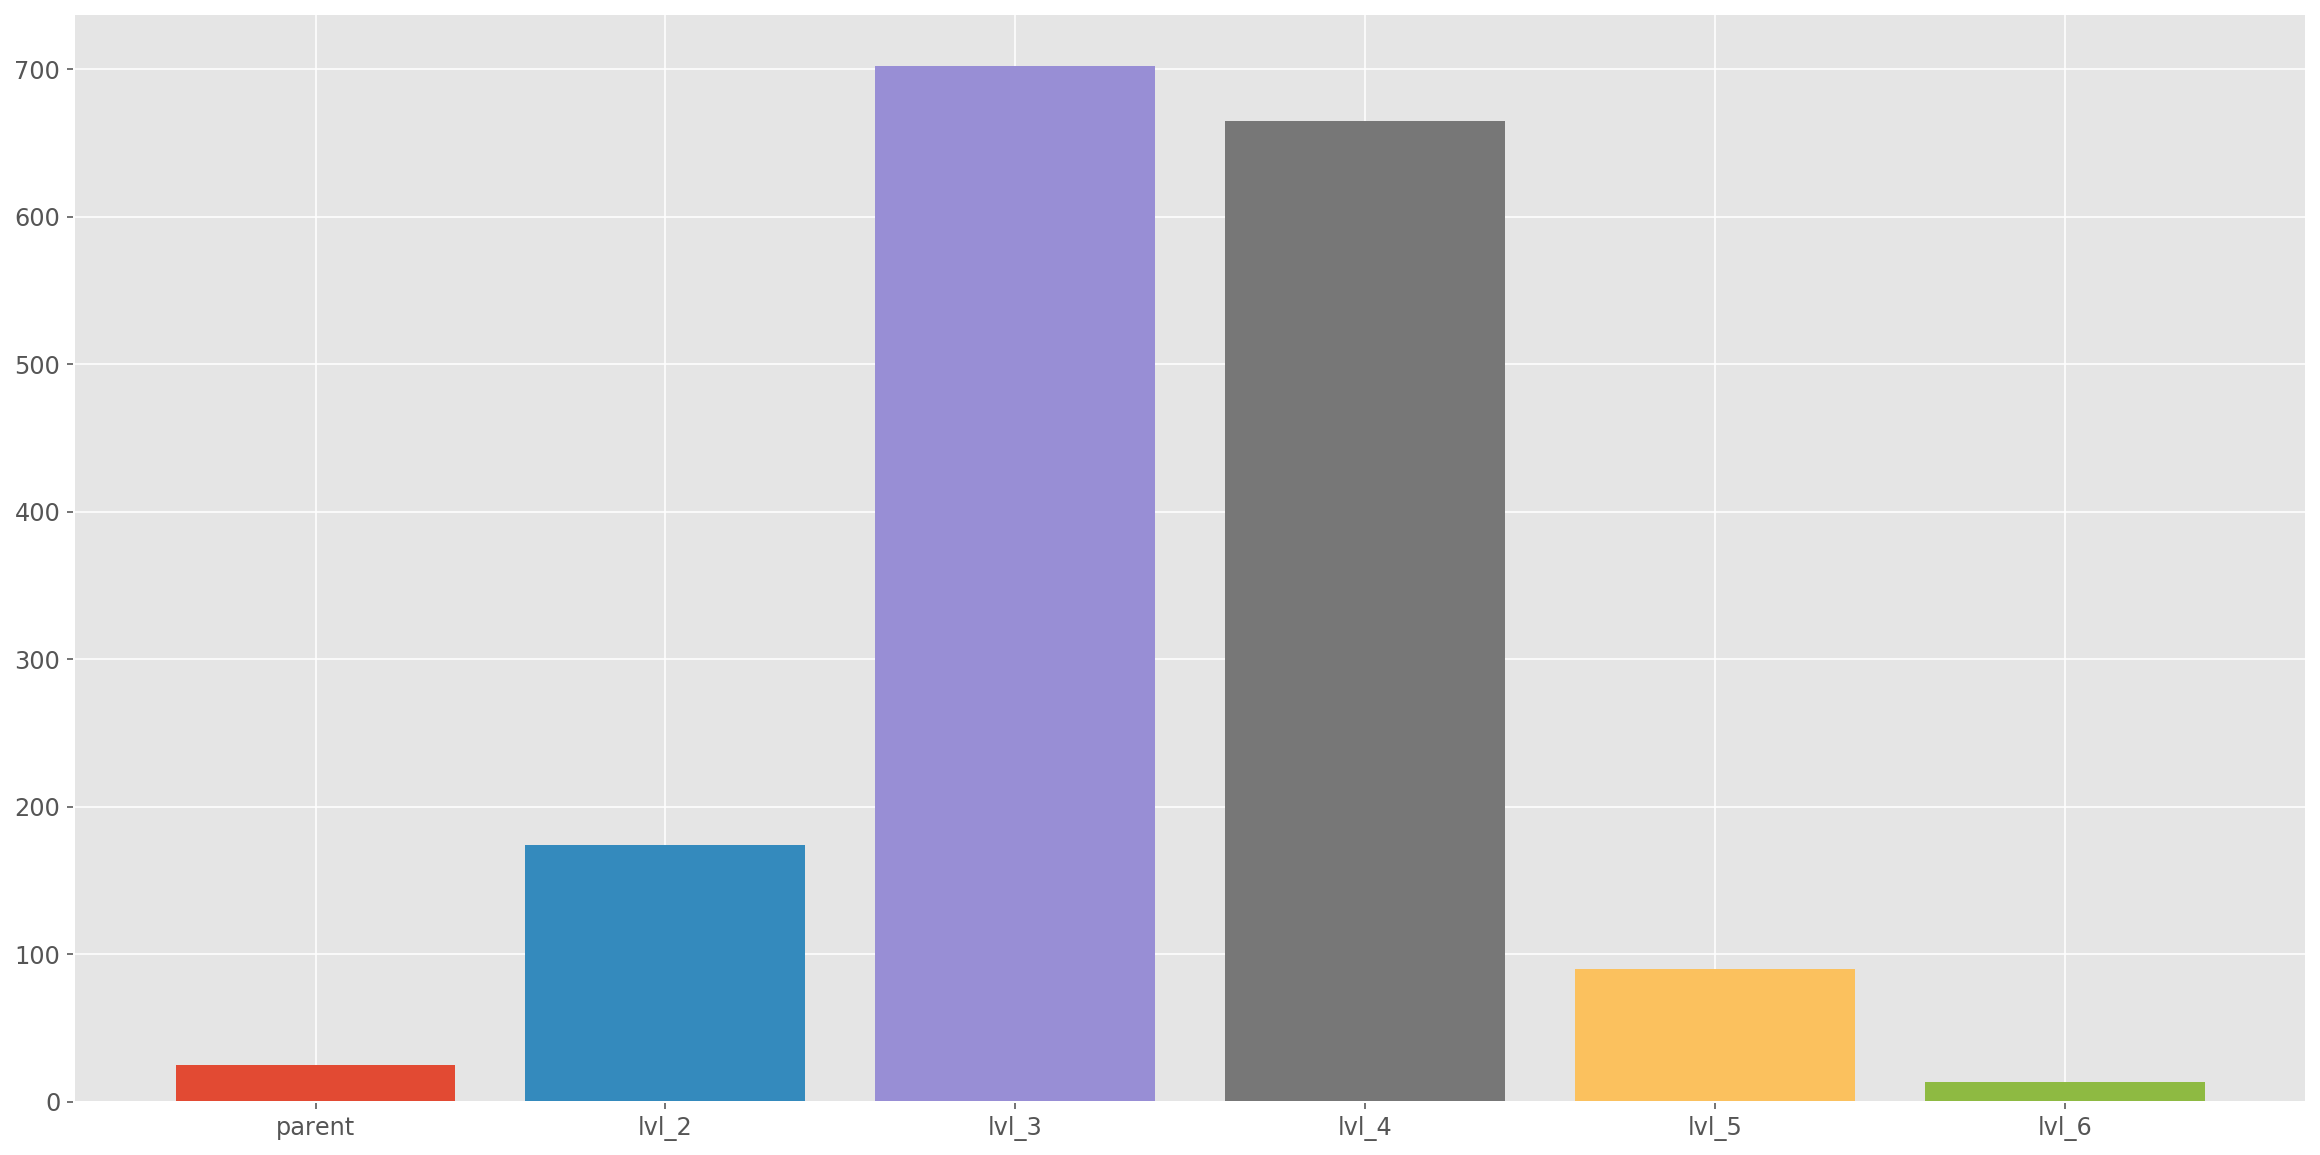

In [463]:
plt.figure(figsize=(20,10))
plt.bar(cat_list[0][0],cat_list[0][1])
plt.bar(cat_list[1][0],cat_list[1][1])
plt.bar(cat_list[2][0],cat_list[2][1])
plt.bar(cat_list[3][0],cat_list[3][1])
plt.bar(cat_list[4][0],cat_list[4][1])
plt.bar(cat_list[5][0],cat_list[5][1])

plt.savefig('Category_list.png')

In [56]:
group_model = modeling_df.groupby(['category_level','Event_Goal']).nunique() 
group_model
#[modeling_df['category_level']==5]

itemid  visitorid  user_product_total_orders  \
category_level Event_Goal                                                 
1              0               77        141                          2   
               1               13         17                          1   
2              0             3434      10224                          4   
               1              594        765                          3   
3              0            30128      92390                          7   
               1             5118       6234                          7   
4              0            37279      84036                          6   
               1             4670       4902                          5   
5              0             3379      10679                          5   
               1              380        544                          4   

                           event  transactionid  Event_Goal  AddtoCart  \
category_level Event_Goal                                                
1              0               2              1           1          2   
               1               1             17           1          1   
2              0               2              1           1          2   
               1               1            954           1          1   
3              0               2              1           1          2   
               1               1           9297           1          1   
4              0               2              1           1          2   
               1               1           7006           1          1   
5              0               2              1           1          2   
               1               1            654           1          1   

                           days_since_last_event  Previous_Visits  \
category_level Event_Goal                                           
1              0                               9               30   
               1                               2                7   
2              0                              87              357   
               1                               8              192   
3              0                             122             1216   
               1                              21              720   
4              0                             123              951   
               1                              21              574   
5              0                              75              248   
               1                               6              115   

                           Day_of_Week_0  ...  Day_of_Week_2  Day_of_Week_3  \
category_level Event_Goal                 ...                                 
1              0                       2  ...              2              2   
               1                       2  ...              2              2   
2              0                       2  ...              2              2   
               1                       2  ...              2              2   
3              0                       2  ...              2              2   
               1                       2  ...              2              2   
4              0                       2  ...              2              2   
               1                       2  ...              2              2   
5              0                       2  ...              2              2   
               1                       2  ...              2              2   

                           Day_of_Week_4  Day_of_Week_5  Day_of_Week_6  \
category_level Event_Goal                                                
1              0                       2              2              2   
               1                       2              2              2   
2              0                       2              2              2   
               1                       2              2              2   
3              

In [57]:
modeling_df.columns

Index(['itemid', 'visitorid', 'user_product_total_orders', 'event',
       'transactionid', 'Event_Goal', 'AddtoCart', 'days_since_last_event',
       'Previous_Visits', 'Day_of_Week_0', 'Day_of_Week_1', 'Day_of_Week_2',
       'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5', 'Day_of_Week_6',
       'Time_of_Day_Afternoon', 'Time_of_Day_Evening', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'category_level'],
      dtype='object')

## Run 6 - Add to cart

In [58]:
run_six = modeling_df.drop(columns=['itemid', 
       'transactionid', 'AddtoCart','days_since_last_event'])

X_tr, X_te, y_tr, y_te = get_user_split_data(run_six)

In [61]:
X_te.columns

Index(['user_product_total_orders', 'Previous_Visits', 'Day_of_Week_0',
       'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4',
       'Day_of_Week_5', 'Day_of_Week_6', 'Time_of_Day_Afternoon',
       'Time_of_Day_Evening', 'Time_of_Day_Morning', 'Time_of_Day_Night',
       'category_level'],
      dtype='object')

In [54]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_tr,y_tr)

In [131]:
score, y_pred, knn6 = knn_classifier(X_resampled, y_resampled, X_te, y_te)
score

0.6023233609166136

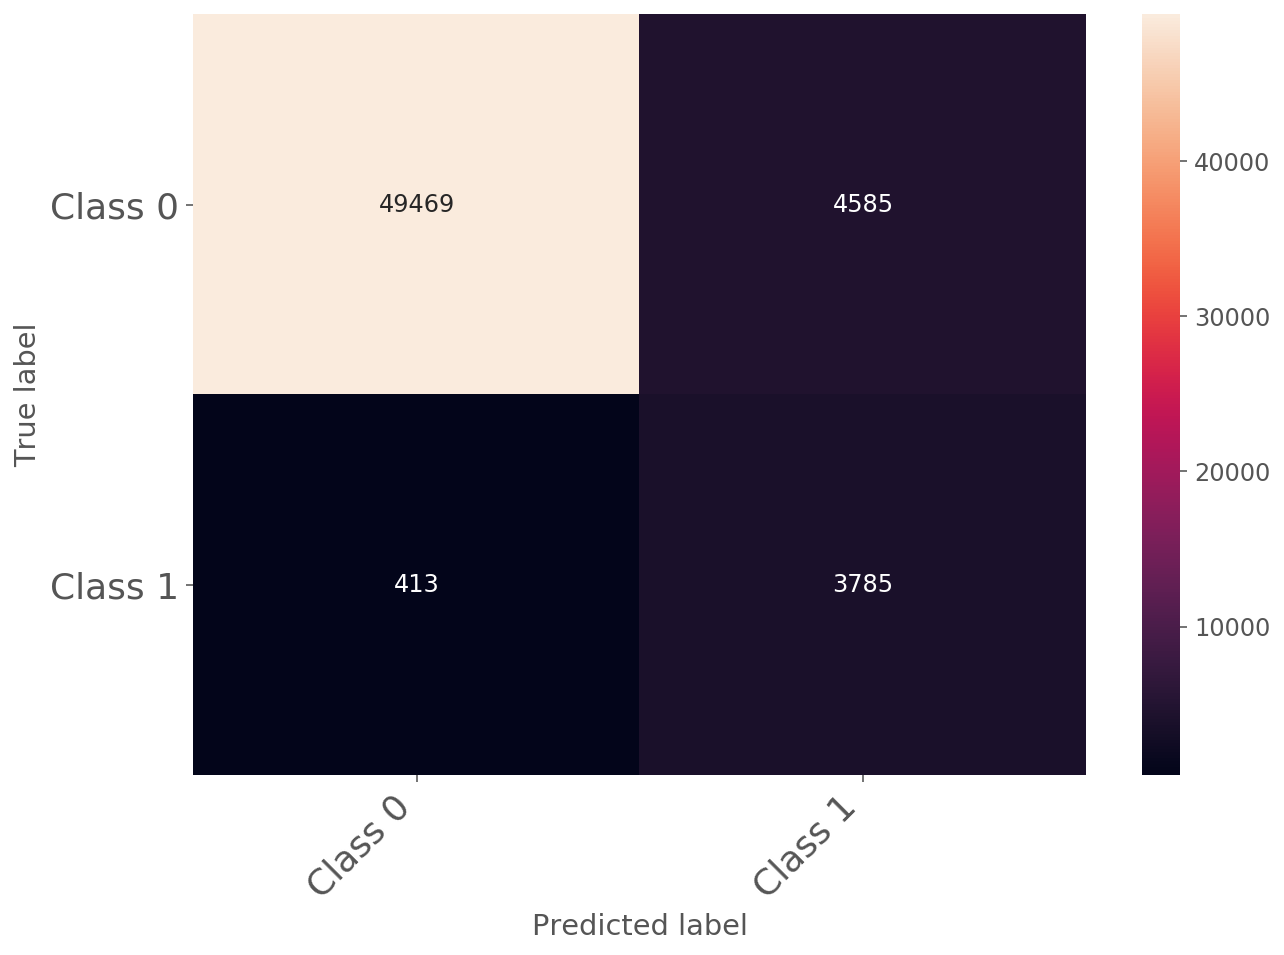

In [132]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])


No change.  Will check on this again after running full data set.  

In [95]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_tr,y_tr)

In [96]:
score, y_pred, knn_smot = knn_classifier(X_smoted, y_smoted, X_te, y_te)
score

0.27987616099071205

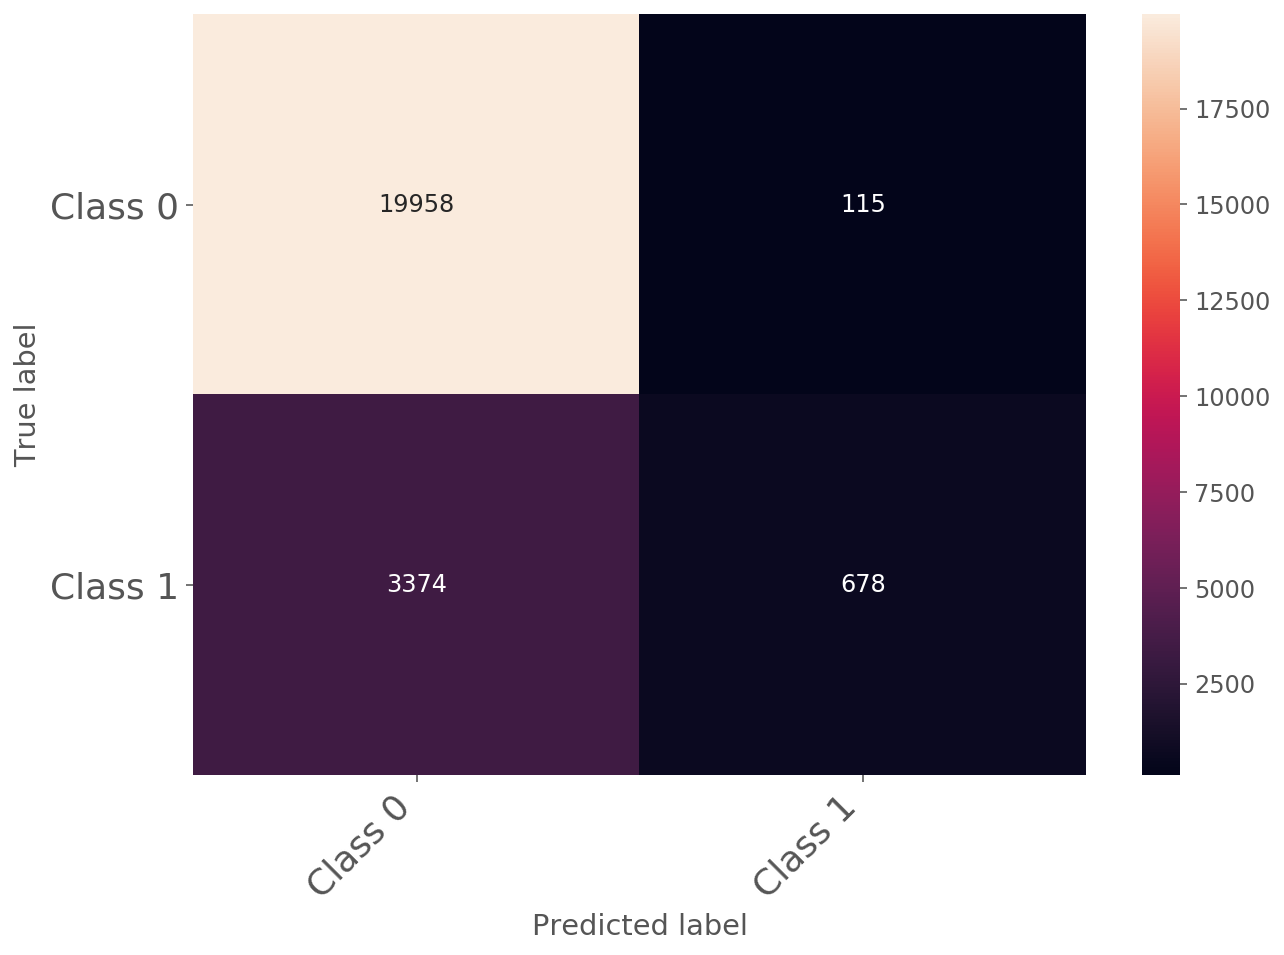

In [97]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])

Smoted is worse so far.  

In [139]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_tr,y_tr)

In [140]:
score, y_pred, knn_ada = knn_classifier(X_adasyn, y_adasyn, X_te, y_te)
score

0.5927825609085913

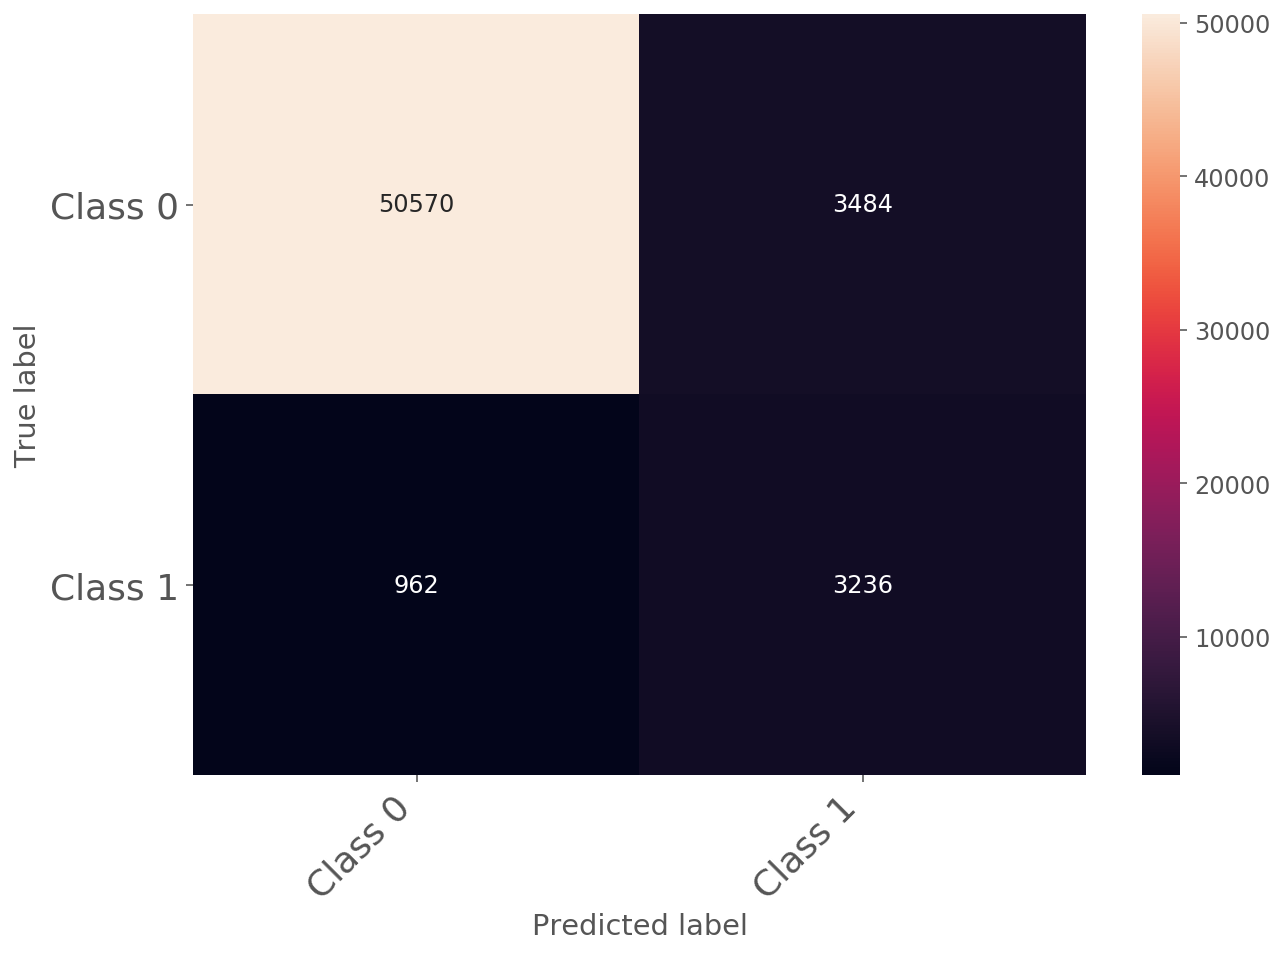

In [141]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])

Random seems best.

In [34]:
score, y_pred, lr1 = log_reg(X_resampled, y_resampled, X_te, y_te, 'lbfgs')
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_te, y_pred), 
                                                     recall_score(y_te, y_pred)))




Precision: 0.2132,   Recall: 1.0000


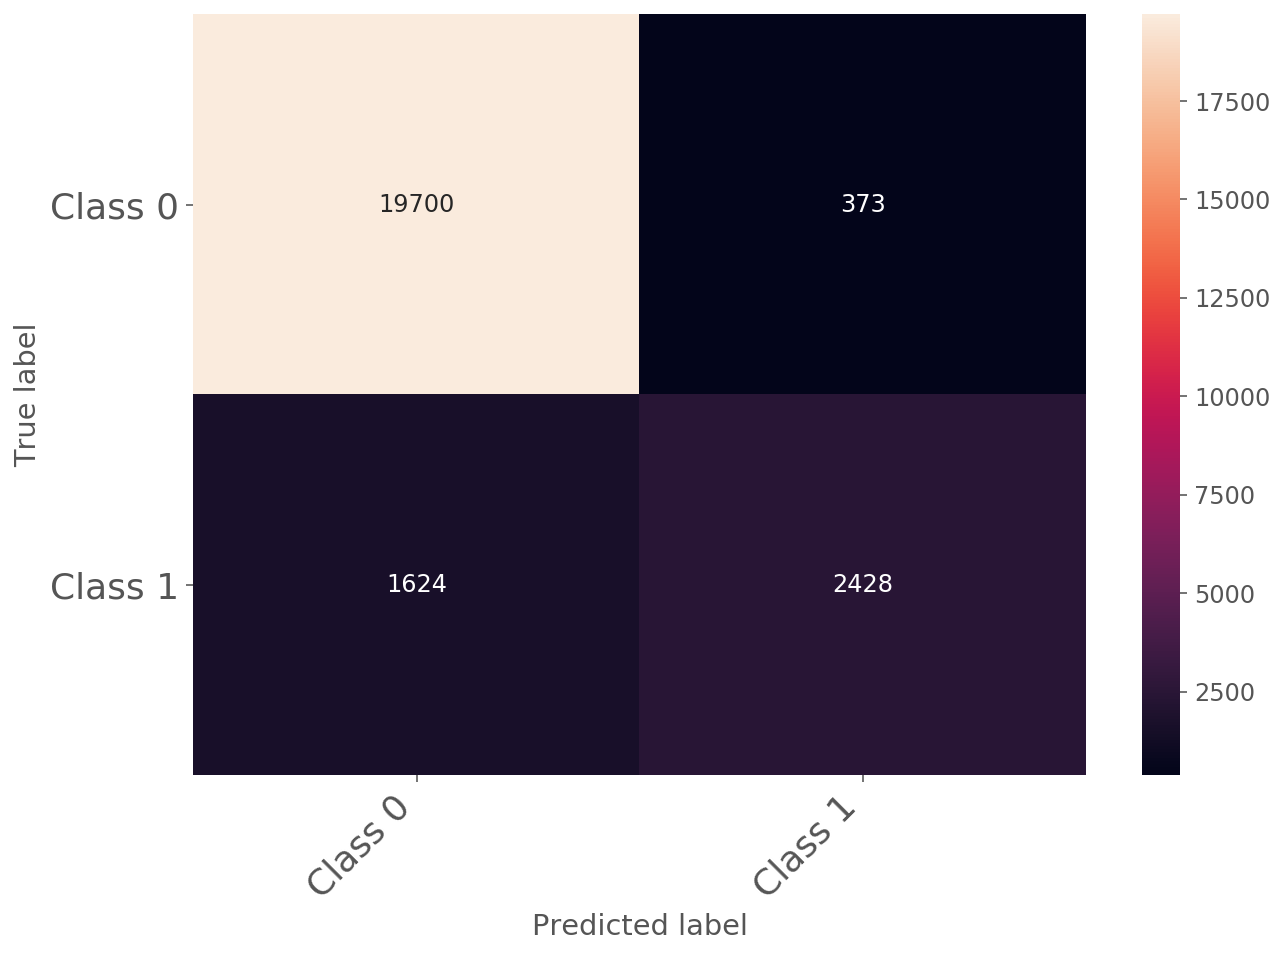

In [101]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_pred), ['Class 0', 'Class 1'])



In [142]:
threshold = .8
lm2 = LogisticRegression(solver='liblinear',C = 100)
lm2.fit(X_resampled, y_resampled)
y_predicted = (lm2.predict_proba(X_te)[:, 1] >= threshold)
print("Logistic score: {:6.4f}".format(lm2.score(X_te,y_te)))

Logistic score: 0.9161


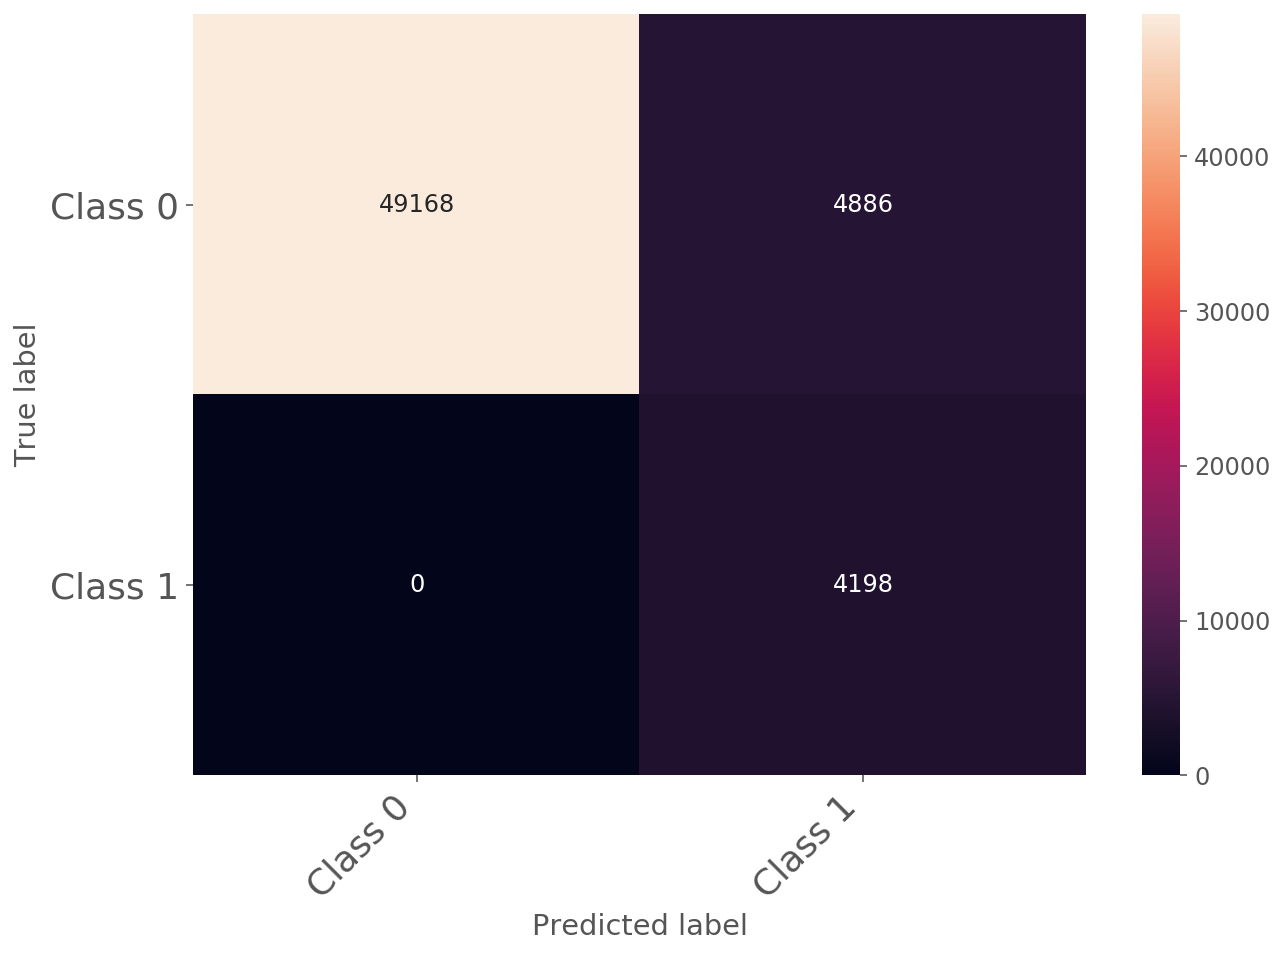

In [143]:
cm = print_confusion_matrix(confusion_matrix(y_te, y_predicted), ['Class 0', 'Class 1'])

In [308]:
lm.coef_

array([[ 2.05948700e+00,  1.59233661e-04, -1.40497084e-03,
         3.64039254e-02, -1.09005415e-02, -8.11694445e-02,
        -2.14067560e-01, -1.91148151e-01,  9.06535795e-02,
        -2.08001773e-01, -9.31768756e-02, -1.31988554e-01]])

In [309]:
X_te.columns

Index(['user_product_total_orders', 'Previous_Visits', 'Day_of_Week_1',
       'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5',
       'Day_of_Week_6', 'Time_of_Day_Evening', 'Time_of_Day_Morning',
       'Time_of_Day_Night', 'category_level'],
      dtype='object')

In [145]:
import pickle
pickle.dump(lm2, open("my_pickled_model.p", "wb"))